In [1]:
%matplotlib inline
%pprint on

Pretty printing has been turned OFF


In [2]:
from sklearn.metrics import f1_score, multilabel_confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import utils
import os
from PIL import Image
import pandas as pd
import json
import torch
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=2)
import json
from gensim.models.keyedvectors import KeyedVectors
from types import SimpleNamespace
from networks import TextEncoder, ImageEncoder, DiscourseClassifier

In [12]:
sz=18

## Weight for auxillary classifier and max_sequence_length

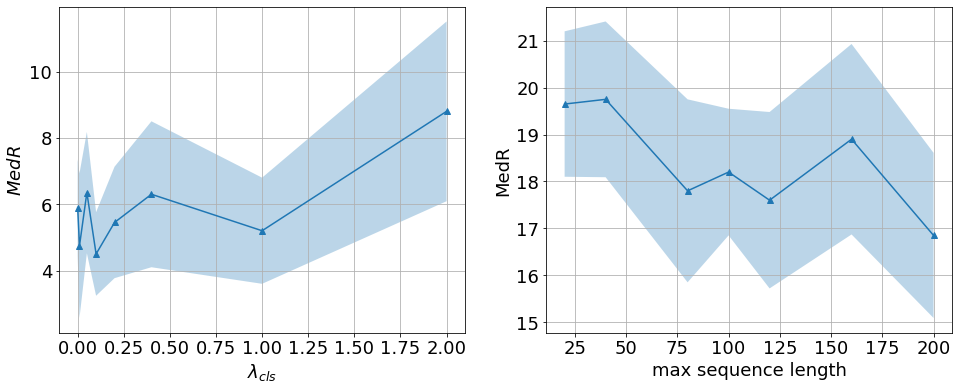

In [122]:
plt.figure(figsize=(16,6))

plt.subplot(121)
# cite
medRs = np.array([5.90, 4.75, 6.35, 4.50, 5.45, 6.30, 5.20, 8.80])
stds = np.array([1.45, 2.18, 1.83, 1.26, 1.68, 2.20, 1.60, 2.71])
lambdas = np.array([0.00, 0.01, 0.05, 0.10, 0.20, 0.40, 1.00, 2.00])

plt.plot(lambdas, medRs, '^-')
plt.fill_between(lambdas, medRs-stds, medRs+stds, alpha=0.3)
plt.xlabel('$\lambda_{cls}$', fontsize=sz)
plt.ylabel('$MedR$', fontsize=sz)
plt.xticks(fontsize=sz)
plt.yticks(fontsize=sz)
plt.grid()

plt.subplot(122)

# cite
max_lens = np.array([50, 100, 200, 300, 400])
medRs = np.array([5.05, 4.70, 4.50, 5.55, 5.50])
stds = np.array([1.43, 1.85, 1.26, 1.63, 2.06])

# clue
max_lens = np.array([20,    40,   80,   100,  120,  160,  200])
medRs =    np.array([19.65, 19.75,      17.80,        18.2,        17.6, 18.9, 16.85])
stds =     np.array([1.55,  1.66,        1.95,          1.35,         1.88, 2.03, 1.76])

plt.plot(max_lens, medRs, '^-')
plt.fill_between(max_lens, medRs-stds, medRs+stds, alpha=0.3)
plt.xlabel('max sequence length', fontsize=sz)
plt.ylabel('MedR', fontsize=sz)
plt.xticks(fontsize=sz)
plt.yticks(fontsize=sz)
plt.grid()

## Truth Rate

In [6]:
from torchvision import transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    normalize
])
from datasets import CoherenceDataset

datasource = 'cite'
cite = CoherenceDataset(
    part='train',
    datasource=datasource,
    word2vec_file=f'models/word2vec_{datasource}.bin',
    dataset_q=0,
    transform=train_transform)

datasource = 'clue'
clue = CoherenceDataset(
    part='train',
    datasource=datasource,
    word2vec_file=f'models/word2vec_{datasource}.bin',
    dataset_q=0,
    transform=train_transform)

vocab size = 8918
vocab size = 5612


In [7]:
print('cite')
n2p_cite = cite.n2p
pos_rate_cite = np.asarray([1/(1+x) for x in n2p_cite])
for x in pos_rate_cite:
    print(f'{x:.3f}')
    
print('clue')
n2p_clue = clue.n2p
pos_rate_clue = np.asarray([1/(1+x) for x in n2p_clue])
for x in pos_rate_clue:
    print(f'{x:.3f}')

cite
0.821
0.115
0.329
0.193
0.158
0.588
0.313
clue
0.674
0.066
0.157
0.243
0.391
0.087


In [8]:
print('cite')
entropies_cite = -pos_rate_cite*np.log(pos_rate_cite)
for x in entropies_cite:
    print(f'{x:.3f}')
    
print('clue')
entropies_clue = -pos_rate_clue*np.log(pos_rate_clue)
for x in entropies_clue:
    print(f'{x:.3f}')

cite
0.162
0.249
0.366
0.318
0.291
0.312
0.364
clue
0.266
0.180
0.290
0.344
0.367
0.212


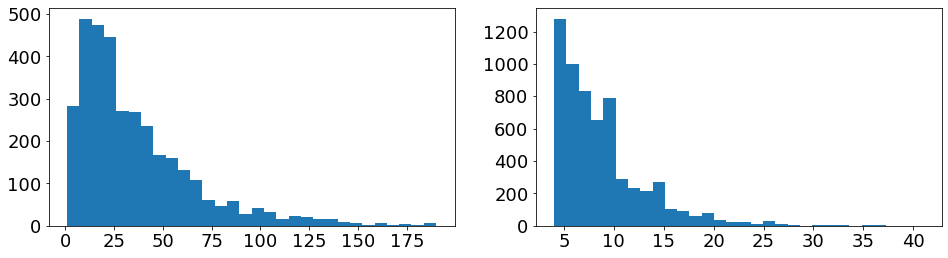

In [34]:
headers = ['stim_txt', 'caption']

plt.figure(figsize=(16,4))
i = 0
for train_set, header in zip([cite, clue], headers):
    lens = [len(x.split()) for x in train_set.recipes[header]]
    plt.subplot(121+i)
    _ = plt.hist(lens, bins=30)
    plt.xticks(fontsize=sz)
    plt.yticks(fontsize=sz)
    i += 1

In [9]:
labels_cite = ['q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8']
# MedRs_cite = [5.1, 4.45, 4.35, 6.25, 5.55, 4.10, 4.05]
MedRs_cite = [4.7, 4.2, 4.2, 3.7, 4.6, 3.9, 5.0]

In [10]:
labels_clue = ['Visible', 'Subjective', 'Action', 'Story', 'Meta', 'Irrelevant']
# MedRs_clue = np.array([21.35, 24.95, 21.15, 18.05, 19.65, 19.85])
MedRs_clue = np.array([19.6, 25.0, 20.9, 17.7, 19.2, 20.3])

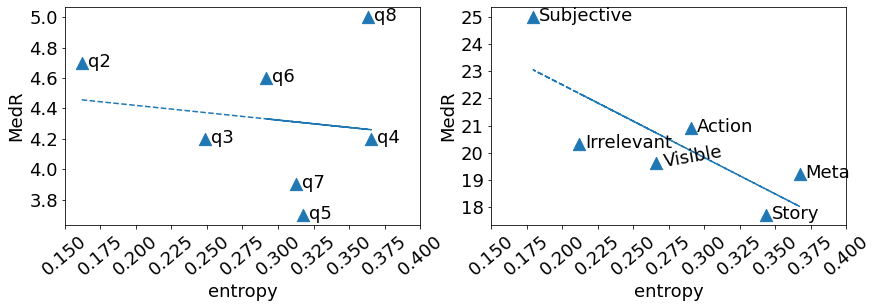

In [13]:
all_entropies = [entropies_cite, entropies_clue]
all_MedRs = [MedRs_cite, MedRs_clue]
all_labels = [labels_cite, labels_clue]

plt.figure(figsize=(14,4))
iplot = 0
for entropies, MedRs, labels in zip(all_entropies, all_MedRs, all_labels):
    plt.subplot(121+iplot)

    plt.scatter(entropies, MedRs, marker='^', s=150)
    i = 0
    for x,y in zip(entropies, MedRs):
        # this method is called for each point
        plt.annotate(labels[i], # this is the text)
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(6,-4), # distance from text to points (x,y)
                     fontsize=sz,
                     rotation=10 if labels[i]=='Visible' else 0,
                     ha='left') # horizontal alignment can be left, right or center
        i+= 1

    plt.xlabel('entropy', fontsize=sz)
    plt.ylabel('MedR', fontsize=sz)

    m, b = np.polyfit(entropies, MedRs, 1)
    plt.plot(entropies, m*entropies + b, '--')
    plt.xticks(np.arange(0.1500, 0.425, 0.025), fontsize=sz, rotation=40)
    plt.yticks(fontsize=sz)
    
    iplot+=1

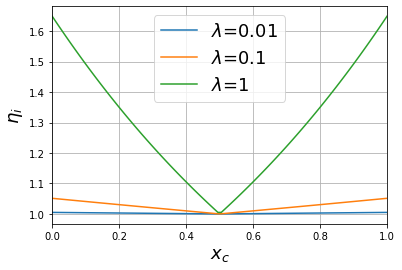

In [14]:
x = np.linspace(0, 1, 100)
lambs = [0.01, 0.1, 1]
for lamb in lambs:
    y = np.exp(lamb*abs(x-0.5))
    plt.plot(x,y, label=f'$\lambda$={lamb}')
plt.grid()
plt.xlabel('$x_c$', fontsize=18)
plt.ylabel('$\eta_i$', fontsize=18)
plt.xlim(0, 1)
plt.legend(fontsize=18)

In [17]:
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.read().split('\n')
    data = []
    for line in lines:
        pos, diff = line.split(',')
        pos = int(pos)
        diff = float(diff)
        data.append([pos, diff])
    return np.array(data)

sim_data = read_data('outputs/sim_0.05.txt')
sim_bar_data = read_data('outputs/sim*CI_0.05.txt')

(378,)


<BarContainer object of 378 artists>

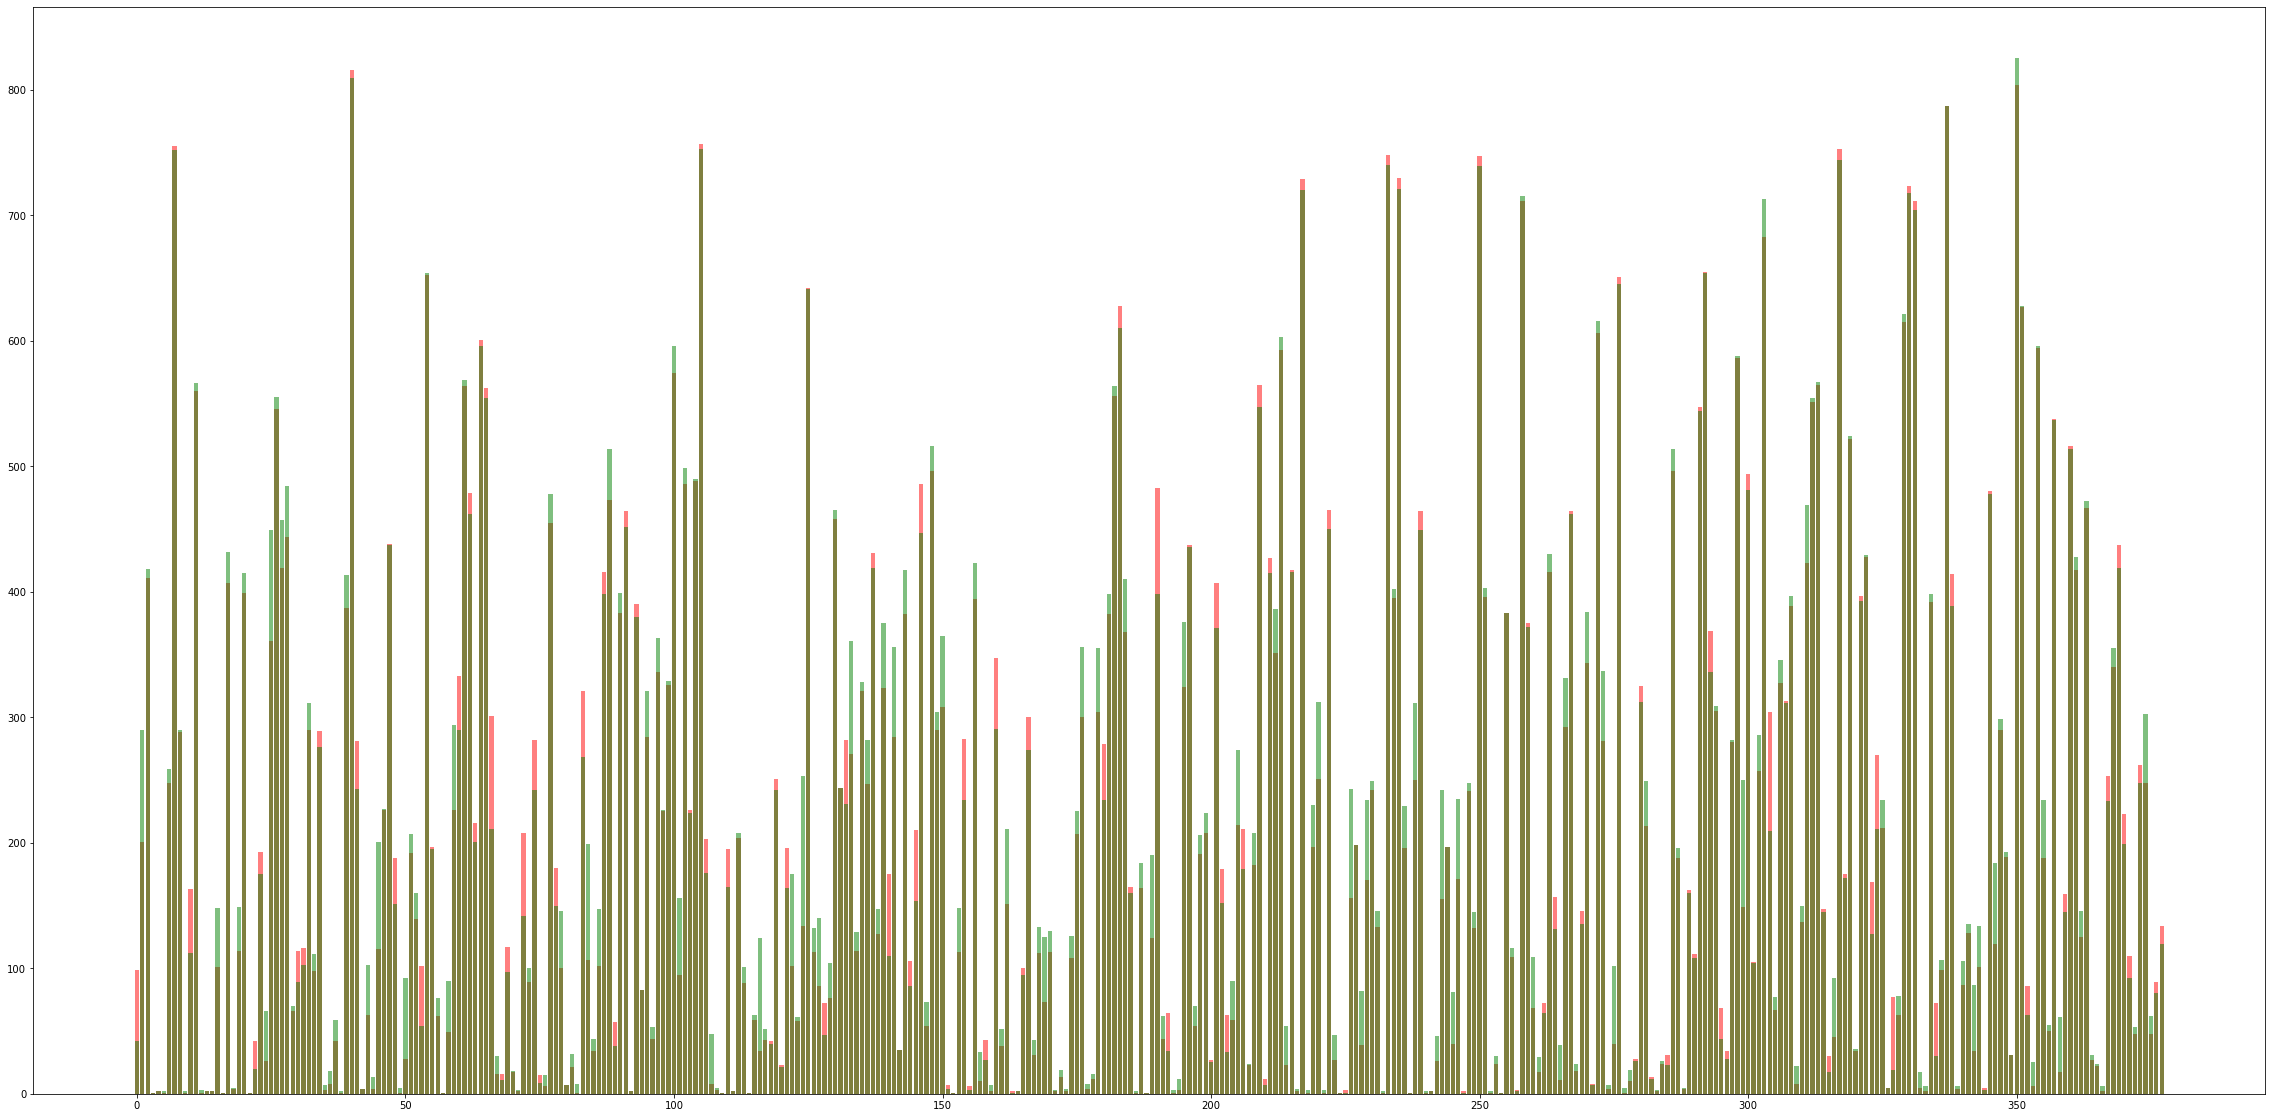

In [31]:
chosen = sim_data[:,1] < 0.05

sim_sub = sim_data[:,0][chosen]
sim_bar_sub = sim_bar_data[:,0][chosen]

print(sim_sub.shape)

plt.figure(figsize=(40,20))
x = range(len(sim_sub))
plt.bar(x, sim_sub, color='r', alpha=0.5)
plt.bar(x, sim_bar_sub, color='g', alpha=0.5)